# Model22: refactor

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from utils import load_buzz, select, write_result
from features import featurize, get_pos
from containers import Questions, Users, Categories
from nlp import extract_entities

## GMM

In [2]:
import pickle


questions = pickle.load(open('questions01.pkl', 'rb'))
users = pickle.load(open('users01.pkl', 'rb'))
categories = pickle.load(open('categories01.pkl', 'rb'))

In [3]:
from sklearn.preprocessing import normalize


X_pos_uid = users.select(['ave_pos_uid', 'acc_ratio_uid'])
X_pos_qid = questions.select(['ave_pos_qid', 'acc_ratio_qid', 'ne_nor_mean', 'ne_mean', 'ne_median'])
X_pos_uid = normalize(X_pos_uid, norm='l1')
X_pos_qid = normalize(X_pos_qid, norm='l1')

In [4]:
print(X_pos_qid[0])
print(X_pos_uid[0])

[ 0.37281988  0.0046272   0.00383057  0.29878473  0.31993763]
[ 0.98978868  0.01021132]


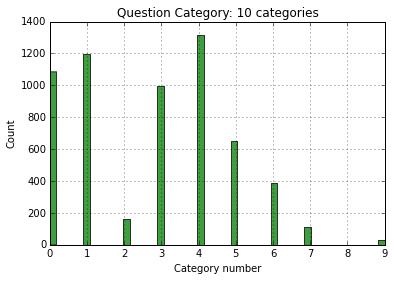

In [5]:
from sklearn.mixture import GMM
from sklearn.cluster import KMeans


# Question category
n_components = 10
est = GMM(n_components=n_components, covariance_type='diag', n_iter=10**10)
est.fit(X_pos_qid)
pred_cat_qid = est.predict(X_pos_qid)

plt.hist(pred_cat_qid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("Question Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

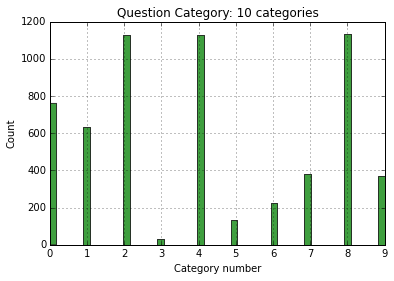

In [6]:
# Question category
n_components = 10
est = KMeans(n_clusters=n_components)
est.fit(X_pos_qid)
pred_cat_qid = est.predict(X_pos_qid)

plt.hist(pred_cat_qid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("Question Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

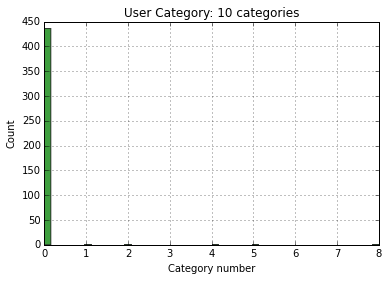

In [7]:
# User category
n_components = 10
est = GMM(n_components=n_components, covariance_type='diag', n_iter=10**10)
est.fit(X_pos_uid)
pred_cat_uid = est.predict(X_pos_uid)

plt.hist(pred_cat_uid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("User Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

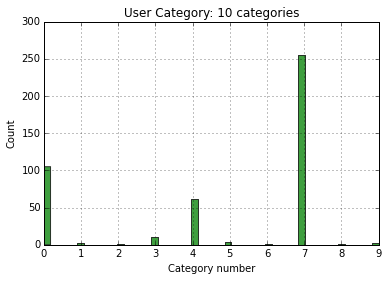

In [8]:
# User category
n_components = 10
est = KMeans(n_clusters=n_components)
est.fit(X_pos_uid)
pred_cat_uid = est.predict(X_pos_uid)

plt.hist(pred_cat_uid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("User Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

In [9]:
from collections import Counter


users.sub_append('cat_uid', {key: str(pred_cat_uid[i]) for i, key in enumerate(users.keys())})
questions.sub_append('cat_qid', {key: str(pred_cat_qid[i]) for i, key in enumerate(questions.keys())})

# to get most frequent cat for some test data which do not have ids in train set
most_pred_cat_uid = Counter(pred_cat_uid).most_common(1)[0][0]
most_pred_cat_qid = Counter(pred_cat_qid).most_common(1)[0][0]

print(most_pred_cat_uid)
print(most_pred_cat_qid)

7
8


In [10]:
print(users.sub_keys())
print(questions.sub_keys())

dict_keys(['cat_uid', 'ave_pos_uid', 'acc_ratio_uid'])
dict_keys(['cat_qid', 'ne_mean', 'question', 'ne_count', 'group', 'acc_ratio_qid', 'pos_token', 'ne_median', 'ne_tags', 'ne_mod', 'category', 'answer', 'ne_nor_mean', 'ave_pos_qid'])


## B. Modeling

In [11]:
def add_features(X):
    for item in X:
        # category
        for key in categories[item['category']].keys():
            item[key] = categories[item['category']][key]
            
        uid = int(item['uid'])
        qid = int(item['qid'])
        
        # uid
        if int(uid) in users:
            item.update(users[uid])
        else:
            acc = users.select(['acc_ratio_uid'])
            item['acc_ratio_uid'] = sum(acc) / float(len(acc))
            item['cat_uid'] = most_pred_cat_uid

        # qid
        if int(qid) in questions:
            item.update(questions[qid])

In [12]:
import pickle


questions = pickle.load(open('questions01.pkl', 'rb'))
users = pickle.load(open('users01.pkl', 'rb'))
categories = pickle.load(open('categories01.pkl', 'rb'))

In [17]:
from utils import load_buzz, select, write_result
from features import featurize, get_pos
from containers import Questions, Users, Categories
from nlp import extract_entities

import math
from collections import Counter

from numpy import abs, sqrt
from sklearn.linear_model import ElasticNetCV
from sklearn.cross_validation import ShuffleSplit, cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans


X_pos_uid = users.select(['ave_pos_uid', 'acc_ratio_uid'])
X_pos_qid = questions.select(['ave_pos_qid', 'acc_ratio_qid', 'ne_nor_mean', 'ne_mean', 'ne_median'])
X_pos_uid = normalize(X_pos_uid, norm='l1')
X_pos_qid = normalize(X_pos_qid, norm='l1')

tu = ('l1', 'n_uid_clust', 'n_qid_clust', 'rmse')
print ('=== Bench with ElasticNetCV: {0}, {1}, {2}, {3}'.format(*tu))
for ii in range(1, 30):
    n_uid_clu = ii
    n_qid_clu = ii
    # clustering for uid
    uid_est = KMeans(n_clusters=n_uid_clu)
    uid_est.fit(X_pos_uid)
    pred_cat_uid = uid_est.predict(X_pos_uid)
    
    # clustering for qid
    qid_est = KMeans(n_clusters=n_qid_clu)
    qid_est.fit(X_pos_qid)
    pred_cat_qid = qid_est.predict(X_pos_qid)
    
    users.sub_append('cat_uid', {key: str(pred_cat_uid[i]) for i, key in enumerate(users.keys())})
    questions.sub_append('cat_qid', {key: str(pred_cat_qid[i]) for i, key in enumerate(questions.keys())})

    # to get most frequent cat for some test data which do not have ids in train set
    most_pred_cat_uid = Counter(pred_cat_uid).most_common(1)[0][0]
    most_pred_cat_qid = Counter(pred_cat_qid).most_common(1)[0][0]

    X_train, y_train = featurize(load_buzz(), group='train',
                                 sign_val=None, extra=['sign_val', 'avg_pos'])
    add_features(X_train)
    unwanted_features = ['ne_tags', 'pos_token', 'question', 'sign_val', 'group']
    wanted_features = list(set(X_train[1].keys()) - set(unwanted_features))
    X_train = select(X_train, wanted_features)

    vec = DictVectorizer()
    X_train_dict_vec = vec.fit_transform(X_train)
    X_new = X_train_dict_vec
    #X_new = LinearSVC(C=0.01, penalty="l1", dual=False, random_state=50).fit_transform(X_train_dict_vec, y_train)
    n_samples = X_new.shape[0]
    cv = ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=50)
    print("L1-based feature selection:", X_train_dict_vec.shape, X_new.shape)
    for l1 in [0.1, 0.3, 0.5, 0.7, 0.9]:
        scores = cross_val_score(ElasticNetCV(n_jobs=3, normalize=True, l1_ratio = l1),
                                 X_new, y_train,
                                 cv=cv, scoring='mean_squared_error')
        rmse = sqrt(abs(scores)).mean()
        print ('{0}, {1}, {2}, {3}'.format(l1, n_uid_clu, n_qid_clu, rmse))

=== Bench with ElasticNetCV: l1, n_uid_clust, n_qid_clust, rmse
L1-based feature selection: (28494, 1049) (28494, 1049)
0.1, 1, 1, 84.57578060945238
0.3, 1, 1, 82.1148184224088
0.5, 1, 1, 79.12109608368117
0.7, 1, 1, 75.47145183860974
0.9, 1, 1, 71.45594523927903
L1-based feature selection: (28494, 1051) (28494, 1051)
0.1, 2, 2, 84.57568152587899
0.3, 2, 2, 82.1148153803562
0.5, 2, 2, 79.11942559261904
0.7, 2, 2, 75.4627057803702
0.9, 2, 2, 71.44633390745075
L1-based feature selection: (28494, 1053) (28494, 1053)
0.1, 3, 3, 84.5751328540744
0.3, 3, 3, 82.11203807259169
0.5, 3, 3, 79.11293836324572
0.7, 3, 3, 75.45244470557566
0.9, 3, 3, 71.43742343218224
L1-based feature selection: (28494, 1055) (28494, 1055)
0.1, 4, 4, 84.57378299857318
0.3, 4, 4, 82.10858157006939
0.5, 4, 4, 79.10763485145633
0.7, 4, 4, 75.44485947608882
0.9, 4, 4, 71.42793644967179
L1-based feature selection: (28494, 1057) (28494, 1057)
0.1, 5, 5, 84.57343861887776
0.3, 5, 5, 82.10565038384527
0.5, 5, 5, 79.09867825

## Some more
Best: 0.7, 27, 27, 75.19373590095874
```
=== Bench with ElasticNetCV: l1, n_uid_clust, n_qid_clust, rmse
L1-based feature selection: (28494, 1049) (28494, 1049)
0.1, 1, 1, 84.57578060945238
0.3, 1, 1, 82.1148184224088
0.5, 1, 1, 79.12109608368117
0.7, 1, 1, 75.47145183860974
0.9, 1, 1, 71.45594523927903
L1-based feature selection: (28494, 1051) (28494, 1051)
0.1, 2, 2, 84.57568152587899
0.3, 2, 2, 82.1148153803562
0.5, 2, 2, 79.11942559261904
0.7, 2, 2, 75.4627057803702
0.9, 2, 2, 71.44633390745075
L1-based feature selection: (28494, 1053) (28494, 1053)
0.1, 3, 3, 84.5751328540744
0.3, 3, 3, 82.11203807259169
0.5, 3, 3, 79.11293836324572
0.7, 3, 3, 75.45244470557566
0.9, 3, 3, 71.43742343218224
L1-based feature selection: (28494, 1055) (28494, 1055)
0.1, 4, 4, 84.57378299857318
0.3, 4, 4, 82.10858157006939
0.5, 4, 4, 79.10763485145633
0.7, 4, 4, 75.44485947608882
0.9, 4, 4, 71.42793644967179
L1-based feature selection: (28494, 1057) (28494, 1057)
0.1, 5, 5, 84.57343861887776
0.3, 5, 5, 82.10565038384527
0.5, 5, 5, 79.09867825925842
0.7, 5, 5, 75.42531850841462
0.9, 5, 5, 71.3990123835524
L1-based feature selection: (28494, 1059) (28494, 1059)
0.1, 6, 6, 84.57360918158693
0.3, 6, 6, 82.10677226453099
0.5, 6, 6, 79.10182118106482
0.7, 6, 6, 75.43212009491992
0.9, 6, 6, 71.41187141072079
L1-based feature selection: (28494, 1061) (28494, 1061)
0.1, 7, 7, 84.49522463188184
0.3, 7, 7, 81.8993188664763
0.5, 7, 7, 78.834790028512
0.7, 7, 7, 75.23312775017592
0.9, 7, 7, 71.41905791032305
L1-based feature selection: (28494, 1063) (28494, 1063)
0.1, 8, 8, 84.4945363221045
0.3, 8, 8, 81.89764549369593
0.5, 8, 8, 78.83246806377203
0.7, 8, 8, 75.22894243535033
0.9, 8, 8, 71.40842667599514
L1-based feature selection: (28494, 1065) (28494, 1065)
0.1, 9, 9, 84.49402168759158
0.3, 9, 9, 81.89625027934729
0.5, 9, 9, 78.83037201799837
0.7, 9, 9, 75.22647569776584
0.9, 9, 9, 71.40763385851653
L1-based feature selection: (28494, 1067) (28494, 1067)
0.1, 10, 10, 84.50511783967579
0.3, 10, 10, 81.9210585895582
0.5, 10, 10, 78.85254662905626
0.7, 10, 10, 75.2253405882006
0.9, 10, 10, 71.38388569872602
L1-based feature selection: (28494, 1069) (28494, 1069)
0.1, 11, 11, 84.53861242167909
0.3, 11, 11, 82.00739274103998
0.5, 11, 11, 78.95861198571109
0.7, 11, 11, 75.29613843062043
0.9, 11, 11, 71.36863432377449
L1-based feature selection: (28494, 1071) (28494, 1071)
0.1, 12, 12, 84.5165490464453
0.3, 12, 12, 81.95493610114364
0.5, 12, 12, 78.90329399584024
0.7, 12, 12, 75.27327562633502
0.9, 12, 12, 71.38458715319594
L1-based feature selection: (28494, 1073) (28494, 1073)
0.1, 13, 13, 84.51501120021993
0.3, 13, 13, 81.95001193833113
0.5, 13, 13, 78.89475238045267
0.7, 13, 13, 75.26206434559977
0.9, 13, 13, 71.37770717268026
L1-based feature selection: (28494, 1075) (28494, 1075)
0.1, 14, 14, 84.51807474401244
0.3, 14, 14, 81.95407863038761
0.5, 14, 14, 78.89218306699232
0.7, 14, 14, 75.25017403221179
0.9, 14, 14, 71.37851511805908
L1-based feature selection: (28494, 1077) (28494, 1077)
0.1, 15, 15, 84.5167894718359
0.3, 15, 15, 81.94927160224736
0.5, 15, 15, 78.88299554114815
0.7, 15, 15, 75.2381951188995
0.9, 15, 15, 71.37565444622496
L1-based feature selection: (28494, 1079) (28494, 1079)
0.1, 16, 16, 84.51737900595941
0.3, 16, 16, 81.95154269484775
0.5, 16, 16, 78.88789962282226
0.7, 16, 16, 75.24667978198865
0.9, 16, 16, 71.3878519856979
L1-based feature selection: (28494, 1081) (28494, 1081)
0.1, 17, 17, 84.5080332079252
0.3, 17, 17, 81.92453296036258
0.5, 17, 17, 78.84619352590035
0.7, 17, 17, 75.19722909090254
0.9, 17, 17, 71.34883263858316
L1-based feature selection: (28494, 1083) (28494, 1083)
0.1, 18, 18, 84.50991008840175
0.3, 18, 18, 81.92978759992448
0.5, 18, 18, 78.85413696174291
0.7, 18, 18, 75.2067764425008
0.9, 18, 18, 71.35814037253866
L1-based feature selection: (28494, 1085) (28494, 1085)
0.1, 19, 19, 84.51316546488042
0.3, 19, 19, 81.93864766990629
0.5, 19, 19, 78.86680939776453
0.7, 19, 19, 75.21999853288706
0.9, 19, 19, 71.36725897235696
L1-based feature selection: (28494, 1087) (28494, 1087)
0.1, 20, 20, 84.51195212272292
0.3, 20, 20, 81.93592517126692
0.5, 20, 20, 78.86410805465633
0.7, 20, 20, 75.22045734083846
0.9, 20, 20, 71.37448501231134
L1-based feature selection: (28494, 1089) (28494, 1089)
0.1, 21, 21, 84.511605521218
0.3, 21, 21, 81.93548762696985
0.5, 21, 21, 78.8649386253938
0.7, 21, 21, 75.22364237520617
0.9, 21, 21, 71.37976106882513
L1-based feature selection: (28494, 1091) (28494, 1091)
0.1, 22, 22, 84.51087890424199
0.3, 22, 22, 81.93244169156102
0.5, 22, 22, 78.85824271111677
0.7, 22, 22, 75.21198165677852
0.9, 22, 22, 71.36542625599056
L1-based feature selection: (28494, 1093) (28494, 1093)
0.1, 23, 23, 84.51060618543082
0.3, 23, 23, 81.93183827261069
0.5, 23, 23, 78.85777919957556
0.7, 23, 23, 75.21277672328364
0.9, 23, 23, 71.37137587553184
L1-based feature selection: (28494, 1095) (28494, 1095)
0.1, 24, 24, 84.51046407398806
0.3, 24, 24, 81.93014086320787
0.5, 24, 24, 78.85226122787022
0.7, 24, 24, 75.20127271231553
0.9, 24, 24, 71.35565157257385
L1-based feature selection: (28494, 1097) (28494, 1097)
0.1, 25, 25, 84.51020836650054
0.3, 25, 25, 81.92961974634359
0.5, 25, 25, 78.85211073205711
0.7, 25, 25, 75.20318253794355
0.9, 25, 25, 71.3599570553778
L1-based feature selection: (28494, 1099) (28494, 1099)
0.1, 26, 26, 84.51072653119873
0.3, 26, 26, 81.93142187984556
0.5, 26, 26, 78.8555513500979
0.7, 26, 26, 75.20800837904444
0.9, 26, 26, 71.36766348441884
L1-based feature selection: (28494, 1101) (28494, 1101)
0.1, 27, 27, 84.50922495899509
0.3, 27, 27, 81.92655110310464
0.5, 27, 27, 78.84650251340042
0.7, 27, 27, 75.19373590095874
0.9, 27, 27, 71.346228479551
L1-based feature selection: (28494, 1103) (28494, 1103)
0.1, 28, 28, 84.51063784335963
0.3, 28, 28, 81.93087985723258
0.5, 28, 28, 78.85408225783141
0.7, 28, 28, 75.20497089600374
0.9, 28, 28, 71.36511032397812
L1-based feature selection: (28494, 1105) (28494, 1105)
0.1, 29, 29, 84.50855674790196
0.3, 29, 29, 81.92502380638736
0.5, 29, 29, 78.84526128756752
0.7, 29, 29, 75.19601647013413
0.9, 29, 29, 71.36066273489853
```

## without LinearSVC

0.7, 10, 10, 75.25881056979816

```
=== Bench with ElasticNetCV: l1, n_uid_clust, n_qid_clust, rmse
L1-based feature selection: (28494, 1051) (28494, 1051)
0.1, 1, 3, 84.57534649317685
0.3, 1, 3, 82.11263941268587
0.5, 1, 3, 79.11384244718742
0.7, 1, 3, 75.45346390097858
0.9, 1, 3, 71.4378086412858
L1-based feature selection: (28494, 1053) (28494, 1053)
0.1, 1, 5, 84.57467245285879
0.3, 1, 5, 82.11053061415627
0.5, 1, 5, 79.10957938105267
0.7, 1, 5, 75.4457645007495
0.9, 1, 5, 71.42593145159542
L1-based feature selection: (28494, 1058) (28494, 1058)
0.1, 1, 10, 84.5742142642894
0.3, 1, 10, 82.1098574823114
0.5, 1, 10, 79.10984226620995
0.7, 1, 10, 75.44824213974319
0.9, 1, 10, 71.43362788414368
L1-based feature selection: (28494, 1051) (28494, 1051)
0.1, 3, 1, 84.57555505849979
0.3, 3, 1, 82.11418138756825
0.5, 3, 1, 79.120126712558
0.7, 3, 1, 75.47035022246448
0.9, 3, 1, 71.45556011686932
L1-based feature selection: (28494, 1053) (28494, 1053)
0.1, 5, 1, 84.57459141145215
0.3, 5, 1, 82.11007259205773
0.5, 5, 1, 79.1101395754378
0.7, 5, 1, 75.45053509281107
0.9, 5, 1, 71.42916676271975
L1-based feature selection: (28494, 1058) (28494, 1058)
0.1, 10, 1, 84.52896529067888
0.3, 10, 1, 81.98410637471612
0.5, 10, 1, 78.93737118582946
0.7, 10, 1, 75.30377666171958
0.9, 10, 1, 71.40834922157099
L1-based feature selection: (28494, 1053) (28494, 1053)
0.1, 3, 3, 84.57515043981692
0.3, 3, 3, 82.1120530347116
0.5, 3, 3, 79.11287701529983
0.7, 3, 3, 75.4521493949316
0.9, 3, 3, 71.43598182927721
L1-based feature selection: (28494, 1057) (28494, 1057)
0.1, 5, 5, 84.57343319868463
0.3, 5, 5, 82.10562299363224
0.5, 5, 5, 79.09863129283644
0.7, 5, 5, 75.42570154429937
0.9, 5, 5, 71.40133293205342
L1-based feature selection: (28494, 1067) (28494, 1067)
0.1, 10, 10, 84.51971402916938
0.3, 10, 10, 81.95899529979458
0.5, 10, 10, 78.8999276776938
0.7, 10, 10, 75.25881056979816
0.9, 10, 10, 71.37874282745224
```

### with LinearSVC

0.7, 5, 5, 75.48915096134026 is the best.

```
=== Bench with ElasticNetCV: l1, n_uid_clust, n_qid_clust, rmse
L1-based feature selection: (28494, 1051) (28494, 19)
0.1, 1, 3, 85.01211664443585
0.3, 1, 3, 83.42666116749486
0.5, 1, 3, 81.19652379197196
0.7, 1, 3, 77.75878120539167
0.9, 1, 3, 71.7588747513696
L1-based feature selection: (28494, 1053) (28494, 19)
0.1, 1, 5, 85.01235794185945
0.3, 1, 5, 83.42720309740886
0.5, 1, 5, 81.19700246117047
0.7, 1, 5, 77.75871121058195
0.9, 1, 5, 71.75831859373145
L1-based feature selection: (28494, 1058) (28494, 18)
0.1, 1, 10, 84.7017110776803
0.3, 1, 10, 82.42564634258406
0.5, 1, 10, 79.45633877931303
0.7, 1, 10, 75.50074862433978
0.9, 1, 10, 70.54368740975592
L1-based feature selection: (28494, 1051) (28494, 18)
0.1, 3, 1, 85.01288983627143
0.3, 3, 1, 83.42883055430877
0.5, 3, 1, 81.19971272925973
0.7, 3, 1, 77.76215196945125
0.9, 3, 1, 71.76029876195547
L1-based feature selection: (28494, 1053) (28494, 18)
0.1, 5, 1, 85.0134980687861
0.3, 5, 1, 83.42948899494378
0.5, 5, 1, 81.19776865859399
0.7, 5, 1, 77.75328585869252
0.9, 5, 1, 71.74440495880292
L1-based feature selection: (28494, 1058) (28494, 18)
0.1, 10, 1, 85.01393926349766
0.3, 10, 1, 83.43128854314631
0.5, 10, 1, 81.20209863597044
0.7, 10, 1, 77.76219921968064
0.9, 10, 1, 71.75801841525193
L1-based feature selection: (28494, 1053) (28494, 19)
0.1, 3, 3, 84.99786053650696
0.3, 3, 3, 83.39378997171498
0.5, 3, 3, 81.16325049755854
0.7, 3, 3, 77.74592873391603
0.9, 3, 3, 71.76506235501631
L1-based feature selection: (28494, 1057) (28494, 18)
0.1, 5, 5, 84.7021638616651
0.3, 5, 5, 82.42556711024288
0.5, 5, 5, 79.45271570827737
0.7, 5, 5, 75.48915096134026
0.9, 5, 5, 70.5253490273597
L1-based feature selection: (28494, 1067) (28494, 18)
0.1, 10, 10, 84.70261929295131
0.3, 10, 10, 82.42755290035703
0.5, 10, 10, 79.45778081441453
0.7, 10, 10, 75.50010686473138
0.9, 10, 10, 70.54222059100623
```

### Training and testing model

In [66]:
X_test = featurize(load_buzz(), group='test', sign_val=None, extra=['avg_pos'])
add_features(X_test)
X_test = select(X_test, wanted_features)

WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no k

In [67]:
X_train[1]

{'acc_ratio_cat': 0.7560975609756098,
 'acc_ratio_qid': 0.875,
 'acc_ratio_uid': 0.6465863453815262,
 'answer': 'thomas cole',
 'ave_pos_cat': 43.640185830429736,
 'ave_pos_qid': 70.5,
 'ave_pos_uid': 96.724899598393577,
 'avg_pos_qid': 51.0,
 'avg_pos_uid': 30.973895582329316,
 'cat_qid': '11',
 'cat_uid': '19',
 'category': 'Fine Arts',
 'group': 'test',
 'ne_count': 12,
 'ne_mean': 56.5,
 'ne_median': 60.5,
 'ne_mod': 65,
 'ne_nor_mean': 0.7243589743589743,
 'q_length': 78,
 'qid': 1,
 'uid': 1}

In [68]:
X_test[1]

{'acc_ratio_cat': 0.65625,
 'acc_ratio_qid': 0.6428571428571429,
 'acc_ratio_uid': 0.6712328767123288,
 'answer': 'david hilbert',
 'ave_pos_cat': 18.712499999999999,
 'ave_pos_qid': 79.857142857142861,
 'ave_pos_uid': 98.863013698630141,
 'avg_pos_qid': 15.571428571428571,
 'avg_pos_uid': 36.31506849315068,
 'cat_qid': '9',
 'cat_uid': '19',
 'category': 'Mathematics',
 'group': 'train',
 'ne_count': 9,
 'ne_mean': 85.11111111111111,
 'ne_median': 97.0,
 'ne_mod': 97,
 'ne_nor_mean': 0.8105820105820106,
 'q_length': 105,
 'qid': 9967,
 'uid': 131}

In [69]:
vec = DictVectorizer()
vec.fit(X_train + X_test)
X_train = vec.transform(X_train)
X_test = vec.transform(X_test)

In [70]:
for l1_ratio in [0.7, 0.72]:
    print('=== l1_ratio:', l1_ratio)
    regressor = linear_model.ElasticNetCV(n_jobs=3, normalize=True, l1_ratio=l1_ratio)
    regressor.fit(X_train, y_train)
    print(regressor.coef_)
    print(regressor.alpha_)
    predictions = regressor.predict(X_test)
    write_result(load_buzz()['test'], predictions, file_name=str(l1_ratio)+'guess_adj.csv', adj=True)

=== l1_ratio: 0.7
[  1.56247575e+01   2.90232147e+01   2.64921982e+01 ...,   2.81880926e-02
   3.65649402e-06  -4.03491259e-03]
0.000404215283508
** Adjust results ***
** tid qid uid: pred_pos, q_length, diff
32193 123840 15 : 34.637656383536715 , 33 , 1.637656383536715
32186 123840 28 : 35.24361207333974 , 33 , 2.24361207333974
32081 123757 1 : 35.36257254320609 , 29 , 6.362572543206092
32067 123750 43 : 26.129213860954515 , 19 , 7.129213860954515
32025 123718 39 : 19.960609291697644 , 13 , 6.960609291697644
32018 123718 13 : 21.105819699128908 , 13 , 8.105819699128908
31997 123709 52 : 33.041388302617 , 17 , 16.041388302617
13083 106213 9 : 36.20669745120626 , 21 , 15.20669745120626
1232 674 161 : 48.29184378264163 , 48 , 0.291843782641628
24990 106373 62 : 30.709411600779525 , 23 , 7.709411600779525

** diff_tot 71.68882498910803
=== l1_ratio: 0.72
[  1.56485094e+01   3.06933469e+01   2.79998630e+01 ...,   2.92317049e-02
   3.56475447e-06  -4.00410242e-03]
0.000392987081188
** Adjus